In [1]:
import ehrapy as ep
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

#adata = ep.io.read_h5ad("../../anndata_objects/adata_02_2023_pneumonia_unspecified_rest.h5ad")

Installed version 0.3.0 of ehrapy is outdated. Newest version is 0.5.0!

/home/thelichking/anaconda3/envs/new_ep_env/lib/python3.8/site-packages/medcat/cat.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Part A

In [2]:
import warnings
warnings.filterwarnings('ignore')
ep.settings.n_jobs=-1

df_a = pd.read_csv("/home/thelichking/Desktop/data_02_2023_NEW_1.csv")
# should remove this earlier
df_a.drop(["language", "religion", "marital_status"], inplace=True, axis=1)
# shift negative values for log_norm -> see #402 in ehrapy, do this after anndata creation!
for neg_col in ["Base Excess_min", "Base Excess_max", "Base Excess_avg", "Excrement_avg", "Excrement_min", "Excrement_max"]:
    abs_min = abs(df_a[neg_col].min())
    df_a[neg_col] = df_a[neg_col] + abs_min

obs_only = list(df_a.columns[215:415])
obs_only.extend(["disease_type_1","disease_type_2","disease_name_1", 
                 "disease_name_2","INTIME", "OUTTIME", 
                 "SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", 
                 "FIRST_CAREUNIT", "LAST_CAREUNIT", "age_in_month"])

adata = ep.ad.df_to_anndata(df_a, columns_obs_only=obs_only)


2023-11-30 09:21:12,444 - root INFO - Transformed passed dataframe into an AnnData object with n_obs x n_vars = `13941` x `232`.


In [3]:
value_counts = adata.obs['disease_type_1'].value_counts()
custom_labels = {category: f"{category} (n={count})" for category, count in value_counts.items()}
adata.obs['disease_type_1_total'] = adata.obs['disease_type_1'].map(custom_labels)
ep.pp.knn_impute(adata, n_neighbors=20)
adata_enc = ep.pp.encode(adata, autodetect=True, encodings="one_hot_encoding")
adata_enc.layers["original_imputed"] = adata_enc.X.copy()
ep.pp.log_norm(adata_enc)
ep.pp.neighbors(adata_enc)
ep.tl.umap(adata_enc)

Running KNN imputation ⠹

2023-11-30 09:27:21,908 - root INFO - The original categorical values `['ethnicity', 'insurance', 'gender']` were added to uns.


Output()

2023-11-30 09:27:22,301 - root INFO - Updated the original layer after encoding.
2023-11-30 09:27:22,713 - root INFO - The original categorical values `['ethnicity', 'insurance', 'gender']` were added to obs.


2023-11-30 09:27:22,874 - root INFO - Column names for numeric variables ['WBC Count_avg', 'Eosinophils_min', 'pO2_avg', 'Creatine Kinase, MB Isoenzyme_min', 'Red Blood Cells_max', 'Cholesterol, Total_max', 'adenosine deaminase_min', 'Red Blood Cells_avg', 'Gamma Glutamyltransferase_min', 'Absolute Lymphocyte Count_max', 'Lymphocytes, Percent_avg', 'Calcium, Total_avg', 'pO2(A)/FO2(I)_min', 'Eosinophils_max', 'Sodium, Whole Blood_avg', 'Lymphocytes, Percent_min', 'PCT_min', 'Eosinophils_avg', 'Platelet Count_max', 'Bilirubin, Indirect_max', 'Basophils_max', 'Excrement_max', 'pO2(A)/FO2(I)_max', 'Creatinine_avg', 'Creatine Kinase (CK)_min', 'Uric Acid, Urine_max', 'Total Bile Acid_min', 'Triglycerides_max', 'Calculated Bicarbonate, Whole Blood_min', 'MCV_avg', 'Lactate_min', 'Eosinophil Count_avg', 'Excrement_min', 'Serum  icteric index_max', 'Methemoglobin_min', 'Protein, Total_max', 'ALB/GLB_min', 'Base Excess_max', 'Basophils Count_max', 'Hematocrit_avg', 'Oxygen Saturation_min', 'Al

findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans.


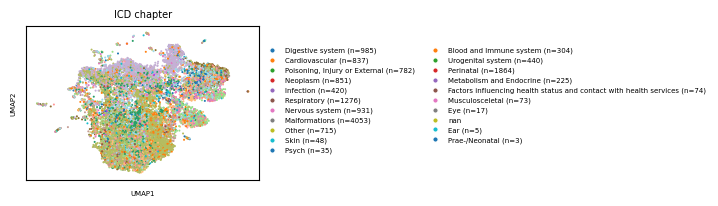

In [34]:
with plt.rc_context({"figure.figsize":(3,2)}):    
    fig = ep.pl.umap(adata_enc, color="disease_type_1_total", return_fig=True)   
    # Manually adjust the legend points' size
    legend_labels = pd.unique(adata.obs['disease_type_1_total'])
    legend_handles_1 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='C{}'.format(i), markersize=4) for i in range(len(legend_labels)//2)]
    legend_handles_2 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='C{}'.format(i), markersize=4) for i in range(len(legend_labels)//2, len(legend_labels))]

  # Create two separate sets of legend labels as strings
    legend_labels_1 = [str(label) for label in legend_labels[:len(legend_labels)//2]]
    legend_labels_2 = [str(label) for label in legend_labels[len(legend_labels)//2:]]

    # Flatten the lists of handles and labels
    all_handles = legend_handles_1 + legend_handles_2
    all_labels = legend_labels_1 + legend_labels_2

    plt.xlabel('UMAP1', fontsize=5, family='helvetica')
    plt.ylabel('UMAP2', fontsize=5, family='helvetica')
    plt.title('ICD chapter', fontsize=7, family='helvetica')
    legend_properties = {'family': 'helvetica', 'size': 5}
    legend = plt.legend(all_handles,all_labels, prop=legend_properties,loc='upper left', bbox_to_anchor=(1, .9), fancybox=False, ncol=2)
    legend.get_frame().set_edgecolor('none')
    legend.get_frame().set_linewidth(0)
    plt.savefig("fig3_disease_types_all.png", bbox_inches='tight', dpi=300)
    plt.show()

In [50]:
diagnoses = pd.read_csv("/home/thelichking/Desktop/DIAGNOSES_ICD.csv")
# ICD codes starting with J indicate respiratory diseases
respiratory_diagnoses = diagnoses[diagnoses['ICD10_CODE_CN'].str.startswith('J')]
respiratory_icd_codes = {"J00–J06": "Acute upper respiratory infections",
"J10–J19": "Influenza and pneumonia",
"J20–J23": "Other acute lower respiratory infections",
"J30–J39": "Other diseases of upper respiratory infections",
"J40–J48": "Chronic lower respiratory diseases",
"J60–J71": "Lung diseases due to external agents",
"J80–J84": "Other respiratory diseases principally affecting the interstitium",
"J85–J87": "Suppurative and necrotic conditions of the lower respiratory tract",
"J90–J94.9": "Other diseases of the pleura",
"J95.0–J95.99": "Intraoperative and postprocedural complications of respiratory system",
"J96–J99": "Other diseases of the respiratory system"}

def get_respiratory_category(value):
    for code_range, category in respiratory_icd_codes.items():
        start, end = code_range.split('–')
        if start <= value <= end:
            return category
    return None

respiratory_diagnoses['Respiratory Category'] = respiratory_diagnoses['ICD10_CODE_CN'].apply(get_respiratory_category)


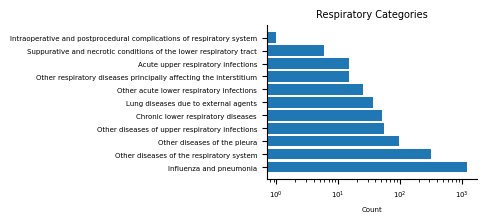

In [52]:
# Import the required libraries
import matplotlib.pyplot as plt

# Count the occurrences of each category
category_counts = respiratory_diagnoses['Respiratory Category'].value_counts()

with plt.rc_context({"figure.figsize":(3,2)}):        
    plt.barh(category_counts.index, category_counts.values)
    plt.xticks(fontsize=5, family="helvetica")  # Remove the x-axis ticks since we're rotating the plot
    plt.yticks(rotation=0, ha='right', fontsize=5, family="helvetica")  # Rotate the y-axis tick labels to 0 degrees
    plt.xlabel('Count', fontsize=5, family='helvetica')
    plt.title('Respiratory Categories', fontsize=7, family='helvetica')
    plt.xscale('log')

    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Set the font style for tick labels
    plt.rcParams['font.family'] = 'helvetica'

    # Adjust the plot layout
    plt.subplots_adjust(left=0.2)  # Increase the left margin to provide more space on the right side

    plt.savefig('respiratory_categories.pdf', dpi=300)

    # Display the plot
    plt.show()

# Part B

In [53]:
df_b = df_a
df_b = df_b.loc[df_a.disease_type_1 == "Respiratory"]
# focus on J10–J19": "Influenza and pneumonia"
respiratory_diagnoses = respiratory_diagnoses.loc[respiratory_diagnoses["Respiratory Category"] == "Influenza and pneumonia"]
pneumonia_influenza_df = df_b[df_b['HADM_ID'].isin(respiratory_diagnoses['HADM_ID'])]

# remove some patients with diseases falsely assigned into the pneumonia and influenza category (most likely due to an annotation failure during the dataset generation)
exclude_diagnoses = ["Pneumothorax, unspecified", "Emphysema, unspecified", "Pulmonary collapse"]
pneumonia_influenza_df = pneumonia_influenza_df[~pneumonia_influenza_df['disease_name_1'].isin(exclude_diagnoses)]

In [54]:
obs_only = list(pneumonia_influenza_df.columns[215:415])
obs_only.extend(["disease_type_1","disease_type_2","disease_name_1", 
                 "disease_name_2","INTIME", "OUTTIME", 
                 "SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", 
                 "FIRST_CAREUNIT", "LAST_CAREUNIT", "age_in_month"])

adata = ep.ad.df_to_anndata(pneumonia_influenza_df, columns_obs_only=obs_only)
ep.pp.knn_impute(adata, n_neighbors=20)
adata_enc = ep.pp.encode(adata, autodetect=True, encodings="one_hot_encoding")
adata_enc.layers["original_imputed"] = adata_enc.X.copy()
ep.pp.log_norm(adata_enc)
ep.pp.neighbors(adata_enc)
ep.tl.umap(adata_enc)

with plt.rc_context({"figure.figsize":(3,2)}):    
    fig = ep.pl.umap(adata_enc, color="disease_name_1", title="Pneumonia subtype", size=100, return_fig=True)
    plt.xlabel('UMAP1', fontsize=5, family='helvetica')
    plt.ylabel('UMAP2', fontsize=5, family='helvetica')
    plt.title('Pneumonia subtype', fontsize=7, family='helvetica')
    legend_properties = {'family': 'helvetica', 'size': 5}
    plt.legend(prop=legend_properties,loc='upper left', bbox_to_anchor=(1, .7))
    plt.savefig("fig3_pneumonia_subtype.png", bbox_inches='tight', dpi=300)

2023-11-30 10:09:45,589 - root INFO - Transformed passed dataframe into an AnnData object with n_obs x n_vars = `976` x `232`.


Quality control metrics missing. Calculating...

TypeError! Setting quality control metrics to nan. Did you encode your data?

2023-11-30 10:09:45,715 - root INFO - Added the calculated metrics to AnnData's `obs` and `var`.


Feature Temperature_avg had more than 42.62% missing values!

Feature Heart Rate_max had more than 43.65% missing values!

Feature pO2(A)/FO2(I)_min had more than 100.00% missing values!

Feature Excrement_avg had more than 55.12% missing values!

Feature Procalcitonin_max had more than 37.09% missing values!

Feature pO2(A)/FO2(I)_max had more than 100.00% missing values!

Feature Systolic Pressure_min had more than 49.39% missing values!

Feature Excrement_max had more than 55.12% missing values!

Feature Respiratory Rate_avg had more than 43.24% missing values!

Feature Diastolic Pressure_min had more than 49.39% missing values!

Feature Excrement_min had more than 55.12% missing values!

Feature Procalcitonin_avg had more than 37.09% missing values!

Feature Systolic Pressure_avg had more than 49.39% missing values!

Feature Temperature_min had more than 42.62% missing values!

Feature Temperature_max had more than 42.62% missing values!

Feature Diastolic Pressure_max had more than 49.39% missing values!

Feature Heart Rate_avg had more than 43.65% missing values!

Feature Systolic Pressure_max had more than 49.39% missing values!

Feature Heart Rate_min had more than 43.65% missing values!

Feature Procalcitonin_min had more than 37.09% missing values!

Feature Respiratory Rate_max had more than 43.24% missing values!

Feature pO2(A)/FO2(I)_avg had more than 100.00% missing values!

Feature Diastolic Pressure_avg had more than 49.39% missing values!

Feature Respiratory Rate_min had more than 43.24% missing values!

scikit-learn-intelex is not available. Install via pip install scikit-learn-intelex  for 
faster imputations.

Output()

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-54-11c17baa4583>:8 in <cell line: 8>                                       │
│                                                                                           │
│ /home/thelichking/Desktop/ehrapy/ehrapy/preprocessing/_data_imputation.py:255 in          │
│ knn_impute                                                                                │
│                                                                                           │
│    252 │   │   │   column_indices = get_column_indices(adata,                             │
│        adata.uns["non_numerical_columns"])                                                │
│    253 │   │   │   adata.X[::, column_indices] = enc.fit_transform(adata.X[::, column_ind │
│    254 │   │   │   # impute the data using KNN imputation                                 │
│ ❱  255 │   │   │   _knn_impute(adata, var_names, n_neighbours)                            │
│    256 │   │   │   # imputing on encoded columns might result in float numbers; those can │
│        be decoded                                                                         │
│    257 │   │   │   # cast them to int to ensure they can be decoded                       │
│    258 │   │   │   adata.X[::, column_indices] = np.rint(adata.X[::,                      │
│        column_indices]).astype(int)                                                       │
│                                                                                           │
│ /home/thelichking/Desktop/ehrapy/ehrapy/preprocessing/_data_imputation.py:292 in          │
│ _knn_impute                                                                               │
│                                                                                           │
│    289 │   │   # this is required since X dtype has to be numerical in order to correctly │
│        floats                                                                             │
│    290 │   │   adata.X = adata.X.astype("float64")                                        │
│    291 │   else:                                                                          │
│ ❱  292 │   │   adata.X = imputer.fit_transform(adata.X)                                   │
│    293                                                                                    │
│    294                                                                                    │
│    295 # ======================  MissForest Impuation =======================             │
│                                                                                           │
│ /home/thelichking/anaconda3/envs/new_ep_env/lib/python3.8/site-packages/anndata/_core/ann │
│ data.py:692 in X                                                                          │
│                                                                                           │
│    689 │   │   │   │   else:                                                              │
│    690 │   │   │   │   │   self._X = value                                                │
│    691 │   │   else:                                                                      │
│ ❱  692 │   │   │   raise ValueError(                                                      │
│    693 │   │   │   │   f"Data matrix has wrong shape {value.shape}, "                     │
│    694 │   │   │   │   f"need to be {self.shape}."                                        │
│    695 │   │   │   )                                                                      │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: Data matrix has wrong shape (976, 229), need to be (976, 232).

# Part C

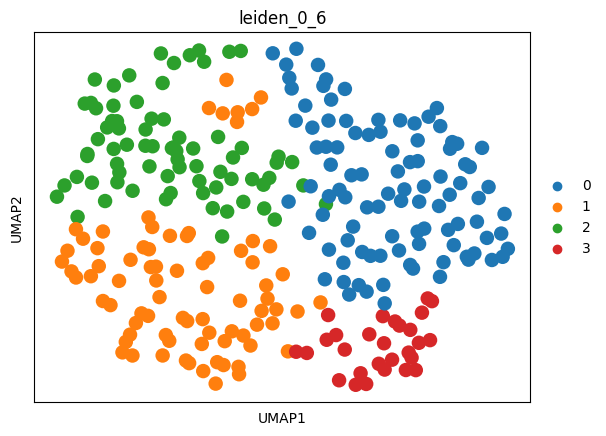

In [3]:
adata = ep.io.read_h5ad("/home/thelichking/Desktop/adata_pneumonia_annotated.h5ad")
ep.tl.leiden(adata, resolution=0.6, key_added="leiden_0_6")
ep.pl.umap(adata, color=["leiden_0_6"])

In [95]:
n_per_cluster = adata.obs['leiden_0_6'].value_counts()

In [4]:
pneumonia_vars = ["Neutrophils_max", "Neutrophils_avg", "Absolute Lymphocyte Count_max", "Absolute Lymphocyte Count_min", "Absolute Lymphocyte Count_avg",
                 "LOS", "Monocytes_max","Monocytes_avg","ehrapycat_sputum_positive_bacteria_1.0", "ehrapycat_sputum_positive_fungi_1.0","ehrapycat_Death_1", "Procalcitonin_max", "C-Reactive Protein_max", ]
pneumonia_adata_subset = adata[:, pneumonia_vars]
ep.tl.rank_features_groups(pneumonia_adata_subset, groupby="leiden_0_6", layer="original_imputed")
pneumonia_adata_subset.obs["Death"] = pneumonia_adata_subset.obs["Death"].astype("category")

/home/thelichking/anaconda3/envs/new_ep_env/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


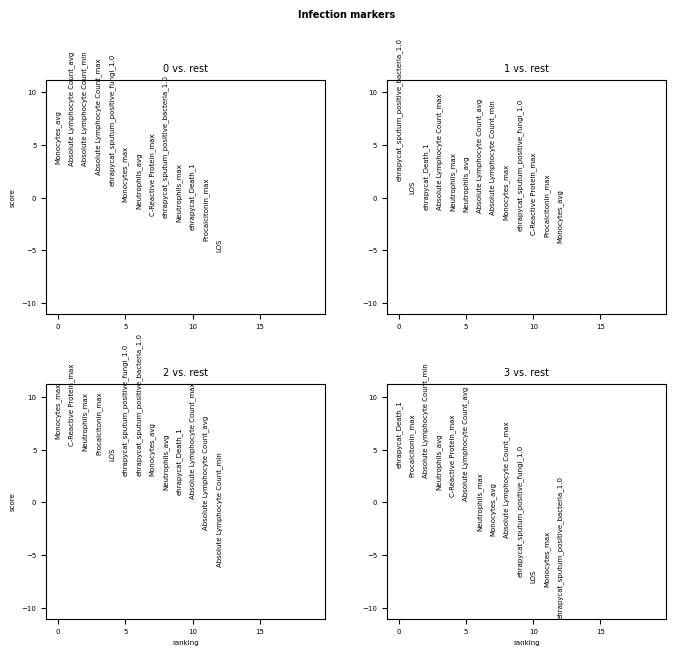

In [149]:
with plt.rc_context({"figure.figsize":(4,3.5)}):    
    ep.pl.rank_features_groups(pneumonia_adata_subset,key="rank_features_groups", ncols=2, fontsize=5, show=False)
    plt.gcf().suptitle("Infection markers", fontsize=7, fontfamily="helvetica", fontweight="bold")
    # Manually set the title font size
    plt.gcf().axes[0].set_title('0 vs. rest', fontsize=7, fontfamily='helvetica')
    plt.gcf().axes[1].set_title('1 vs. rest', fontsize=7, fontfamily='helvetica')
    plt.gcf().axes[2].set_title('2 vs. rest', fontsize=7, fontfamily='helvetica')
    plt.gcf().axes[3].set_title('3 vs. rest', fontsize=7, fontfamily='helvetica')

    font_properties = {'family': 'helvetica', 'size': 5}

    for axis in [0,1,2,3]:
        for label in plt.gcf().axes[axis].get_xticklabels() + plt.gcf().axes[axis].get_yticklabels():
            label.set_fontproperties(font_properties)

    plt.gcf().axes[2].set_xlabel('ranking', fontdict=font_properties)
    plt.gcf().axes[3].set_xlabel('ranking', fontdict=font_properties)

    plt.gcf().axes[0].set_ylabel('score', fontdict=font_properties)
    plt.gcf().axes[2].set_ylabel('score', fontdict=font_properties)
    
    plt.savefig("sup_1_infection_markers", bbox_inches='tight', dpi=300)
    plt.show()

In [150]:
liver_vars = ["Cholinesterase_min", "Gamma Glutamyltransferase_max", "Gamma Glutamyltransferase_avg",
               "Alanine Aminotransferase (ALT)_max", "Alanine Aminotransferase (ALT)_avg",
                "Prealbumin_min", "Prealbumin_max", "Albumin_min", "Albumin_max",
                "Asparate Aminotransferase (AST)_max", "Asparate Aminotransferase (AST)_avg", "Bilirubin, Total_max"]
liver_adata_subset = adata[:, liver_vars]
ep.tl.rank_features_groups(liver_adata_subset, groupby="leiden_0_6", layer="original_imputed")

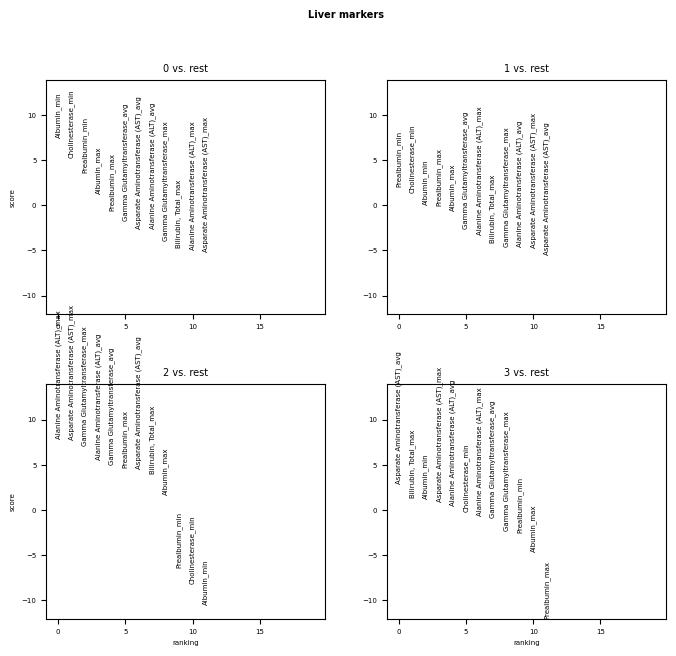

In [152]:
with plt.rc_context({"figure.figsize":(4,3.5)}):    
    ep.pl.rank_features_groups(liver_adata_subset,key="rank_features_groups", ncols=2, fontsize=5, show=False)
    plt.gcf().suptitle("Liver markers", fontsize=7, fontfamily="helvetica", fontweight="bold")
    # Manually set the title font size
    plt.gcf().axes[0].set_title('0 vs. rest', fontsize=7, fontfamily='helvetica')
    plt.gcf().axes[1].set_title('1 vs. rest', fontsize=7, fontfamily='helvetica')
    plt.gcf().axes[2].set_title('2 vs. rest', fontsize=7, fontfamily='helvetica')
    plt.gcf().axes[3].set_title('3 vs. rest', fontsize=7, fontfamily='helvetica')

    font_properties = {'family': 'helvetica', 'size': 5}

    for axis in [0,1,2,3]:
        for label in plt.gcf().axes[axis].get_xticklabels() + plt.gcf().axes[axis].get_yticklabels():
            label.set_fontproperties(font_properties)

    plt.gcf().axes[2].set_xlabel('ranking', fontdict=font_properties)
    plt.gcf().axes[3].set_xlabel('ranking', fontdict=font_properties)

    plt.gcf().axes[0].set_ylabel('score', fontdict=font_properties)
    plt.gcf().axes[2].set_ylabel('score', fontdict=font_properties)
    
    plt.savefig("sup_1_liver_markers", bbox_inches='tight', dpi=300)
    plt.show()

In [154]:
chlinical_chemie = ["Creatinine_max", "Platelet Count_min", "Lactate_max", "Calcium, Total_max", "Calcium, Total_min", "Potassium_max", "Potassium_min",
            "pH_min", "pH_max", "Sodium, Whole Blood_min", "Sodium, Whole Blood_max", "Chloride, Whole Blood_min", "Chloride, Whole Blood_max"]
cc_adata_subset = adata[:, chlinical_chemie]
ep.tl.rank_features_groups(cc_adata_subset, groupby="leiden_0_6", layer="original_imputed")

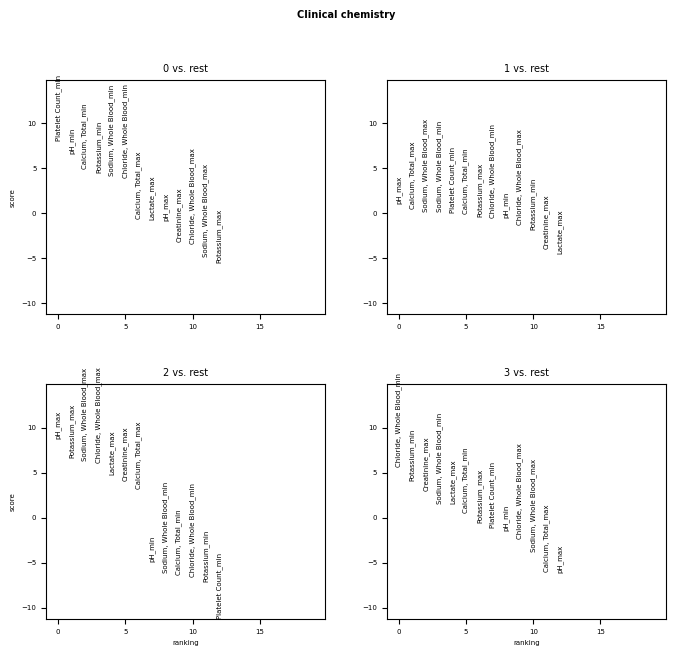

In [155]:
with plt.rc_context({"figure.figsize":(4,3.5)}):    
    ep.pl.rank_features_groups(cc_adata_subset,key="rank_features_groups", ncols=2, fontsize=5, show=False)
    plt.gcf().suptitle("Clinical chemistry", fontsize=7, fontfamily="helvetica", fontweight="bold")
    # Manually set the title font size
    plt.gcf().axes[0].set_title('0 vs. rest', fontsize=7, fontfamily='helvetica')
    plt.gcf().axes[1].set_title('1 vs. rest', fontsize=7, fontfamily='helvetica')
    plt.gcf().axes[2].set_title('2 vs. rest', fontsize=7, fontfamily='helvetica')
    plt.gcf().axes[3].set_title('3 vs. rest', fontsize=7, fontfamily='helvetica')

    font_properties = {'family': 'helvetica', 'size': 5}

    for axis in [0,1,2,3]:
        for label in plt.gcf().axes[axis].get_xticklabels() + plt.gcf().axes[axis].get_yticklabels():
            label.set_fontproperties(font_properties)

    plt.gcf().axes[2].set_xlabel('ranking', fontdict=font_properties)
    plt.gcf().axes[3].set_xlabel('ranking', fontdict=font_properties)

    plt.gcf().axes[0].set_ylabel('score', fontdict=font_properties)
    plt.gcf().axes[2].set_ylabel('score', fontdict=font_properties)
    
    plt.savefig("sup_1_cc_markers", bbox_inches='tight', dpi=300)
    plt.show()

In [157]:
drugs_vars = [drug_column for drug_column in adata.var_names if "received" in drug_column and "1.0" in drug_column] # no duplicated encodes needed
drug_adata_subset = adata[:, drugs_vars]
ep.tl.rank_features_groups(drug_adata_subset, groupby="leiden_0_6", layer="original_imputed")

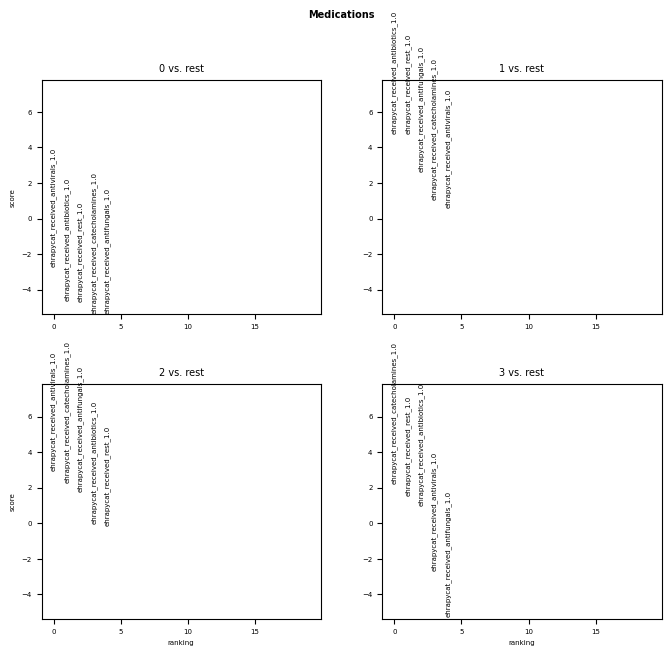

In [158]:
with plt.rc_context({"figure.figsize":(4,3.5)}):    
    ep.pl.rank_features_groups(drug_adata_subset,key="rank_features_groups", ncols=2, fontsize=5, show=False)
    plt.gcf().suptitle("Medications", fontsize=7, fontfamily="helvetica", fontweight="bold")
    # Manually set the title font size
    plt.gcf().axes[0].set_title('0 vs. rest', fontsize=7, fontfamily='helvetica')
    plt.gcf().axes[1].set_title('1 vs. rest', fontsize=7, fontfamily='helvetica')
    plt.gcf().axes[2].set_title('2 vs. rest', fontsize=7, fontfamily='helvetica')
    plt.gcf().axes[3].set_title('3 vs. rest', fontsize=7, fontfamily='helvetica')

    font_properties = {'family': 'helvetica', 'size': 5}

    for axis in [0,1,2,3]:
        for label in plt.gcf().axes[axis].get_xticklabels() + plt.gcf().axes[axis].get_yticklabels():
            label.set_fontproperties(font_properties)

    plt.gcf().axes[2].set_xlabel('ranking', fontdict=font_properties)
    plt.gcf().axes[3].set_xlabel('ranking', fontdict=font_properties)

    plt.gcf().axes[0].set_ylabel('score', fontdict=font_properties)
    plt.gcf().axes[2].set_ylabel('score', fontdict=font_properties)
    
    plt.savefig("sup_1_medications", bbox_inches='tight', dpi=300)
    plt.show()

In [46]:
annotation = {
    "2": "severe pneumonia with co-infection (n=74)",
    "0": "viral pneumonia (n=97)",   
    "3": "sepsis-like pneumonia (n=28)",
    "1": "mild bacterial pneumonia (n=78)" 
}



pneumonia_adata_subset.obs["Pneumonia unspecified - annotated"] = [
    annotation[l] if l in annotation.keys() else l for l in adata.obs["leiden_0_6"]
]

In [48]:
with plt.rc_context({"figure.figsize":(3,2)}):    
    fig = ep.pl.umap(pneumonia_adata_subset, color="Pneumonia unspecified - annotated", size=100, return_fig=True)
    # Manually adjust the legend points' size
    legend_labels = pd.unique(adata.obs['Pneumonia unspecified - annotated'])
    legend_handles_1 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='C{}'.format(i), markersize=4) for i in range(len(legend_labels)//2)]
    legend_handles_2 = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='C{}'.format(i), markersize=4) for i in range(len(legend_labels)//2, len(legend_labels))]

    # Create two separate sets of legend labels as strings
    legend_labels_1 = [str(label) for label in legend_labels[:len(legend_labels)//2]]
    legend_labels_2 = [str(label) for label in legend_labels[len(legend_labels)//2:]]

    # Flatten the lists of handles and labels
    all_handles = legend_handles_1 + legend_handles_2
    all_labels = legend_labels_1 + legend_labels_2
    
    plt.xlabel('UMAP1', fontsize=5, family='helvetica')
    plt.ylabel('UMAP2', fontsize=5, family='helvetica')
    plt.title('Pneumonia unspecified - annotated', fontsize=7, family='helvetica')
    legend_properties = {'family': 'helvetica', 'size': 5}
    legend = plt.legend(all_handles, all_labels, prop=legend_properties,loc='upper left', bbox_to_anchor=(1, .7), fancybox=False)
    legend.get_frame().set_edgecolor('none')
    legend.get_frame().set_linewidth(0)
    plt.savefig("fig3_anot_pneumonia.png", bbox_inches='tight', dpi=300)

In [31]:
ep.io.write("./adata_pneumonia_annotated.h5ad", adata)

2023-11-29 19:19:18,161 - root INFO - Wrote AnnData object to a .h5ad file with filename `adata_pneumonia_annotated.h5ad`.h5ad.


In [57]:
pneumonia_adata_subset.uns["rank_genes_groups"] = pneumonia_adata_subset.uns.pop("rank_features_groups")
pneumonia_df_0 = sc.get.rank_genes_groups_df(pneumonia_adata_subset, group="0")
pneumonia_df_1 = sc.get.rank_genes_groups_df(pneumonia_adata_subset, group="1")
pneumonia_df_2 = sc.get.rank_genes_groups_df(pneumonia_adata_subset, group="2")
pneumonia_df_3 = sc.get.rank_genes_groups_df(pneumonia_adata_subset, group="3")

In [58]:
drug_adata_subset.uns["rank_genes_groups"] = drug_adata_subset.uns.pop("rank_features_groups")
drug_df_0 = sc.get.rank_genes_groups_df(drug_adata_subset, group="0")
drug_df_1 = sc.get.rank_genes_groups_df(drug_adata_subset, group="1")
drug_df_2 = sc.get.rank_genes_groups_df(drug_adata_subset, group="2")
drug_df_3 = sc.get.rank_genes_groups_df(drug_adata_subset, group="3")

In [59]:
cc_adata_subset.uns["rank_genes_groups"] = cc_adata_subset.uns.pop("rank_features_groups")
cc_df_0 = sc.get.rank_genes_groups_df(cc_adata_subset, group="0")
cc_df_1 = sc.get.rank_genes_groups_df(cc_adata_subset, group="1")
cc_df_2 = sc.get.rank_genes_groups_df(cc_adata_subset, group="2")
cc_df_3 = sc.get.rank_genes_groups_df(cc_adata_subset, group="3")

In [60]:
liver_adata_subset.uns["rank_genes_groups"] = liver_adata_subset.uns.pop("rank_features_groups")
liver_df_0 = sc.get.rank_genes_groups_df(liver_adata_subset, group="0")
liver_df_1 = sc.get.rank_genes_groups_df(liver_adata_subset, group="1")
liver_df_2 = sc.get.rank_genes_groups_df(liver_adata_subset, group="2")
liver_df_3 = sc.get.rank_genes_groups_df(liver_adata_subset, group="3")

In [61]:
hm_features = ["ehrapycat_Death_1", "LOS", "ehrapycat_sputum_positive_bacteria_1.0","ehrapycat_sputum_positive_fungi_1.0",
               "Absolute Lymphocyte Count_max", "Neutrophils_max", 
               "Procalcitonin_max", "C-Reactive Protein_max", "Alanine Aminotransferase (ALT)_avg", 
               "Asparate Aminotransferase (AST)_max", "Gamma Glutamyltransferase_max", "Platelet Count_min"]

In [62]:
pneumonia_dfs = [pneumonia_df_0, pneumonia_df_1, pneumonia_df_2, pneumonia_df_3]
liver_dfs = [liver_df_0, liver_df_1, liver_df_2, liver_df_3]
cc_dfs = [cc_df_0, cc_df_1, cc_df_2, cc_df_3]

In [63]:
temp_ls = []
for pneu_feat in hm_features[:8]:
    for df in pneumonia_dfs:
        row = df.loc[df.names == pneu_feat].iloc[0].to_list()
        temp_ls.append(row)

for liver_feat in hm_features[8:11]:
    for df in liver_dfs:
        row = df.loc[df.names == liver_feat].iloc[0].to_list()
        temp_ls.append(row)

for cc_feat in hm_features[11:]:
    for df in cc_dfs:
        row = df.loc[df.names == cc_feat].iloc[0].to_list()
        temp_ls.append(row)

In [64]:
temp_df = pd.DataFrame(temp_ls, columns=["name", "score", "logfoldchange", "pval", "pval_adj"])
temp_df.drop(["logfoldchange", "pval", "pval_adj", "name"], axis=1, inplace=True)

In [65]:
result = pd.DataFrame(temp_df.values.reshape(-1,4)).T
result.columns = ["death","length of stay", "sputum_pos_bacteria", "sputum_pos_fungi", "lymphocytes", "neutrophils", "PCT", "CRP", "ALT", "AST", "GGT", "platelets count"]

updated_column_names = {
    'sputum_pos_bacteria': 'sputum bacteria',
    'sputum_pos_fungi': 'sputum fungi',
    'platelets count': 'platelets'
}
result.rename(columns=updated_column_names, inplace=True)

In [66]:
# we need to add age_in_month as well (its not added to var so its added independetly here)
# the score is not important it should just show an overview how the groups behave differently
from sklearn.preprocessing import MinMaxScaler
age_df = pneumonia_adata_subset.obs[["age_in_month", "Pneumonia unspecified - annotated"]]
avg_age = age_df.groupby('Pneumonia unspecified - annotated')['age_in_month'].mean().reset_index()
# Rename the columns for clarity (optional)
avg_age.columns = ['Pneumonia unspecified - annotated', 'avg age']
result["age in month"] = avg_age["avg age"]/10 # to get in line wit the scores of the other values
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(result), columns=result.columns)

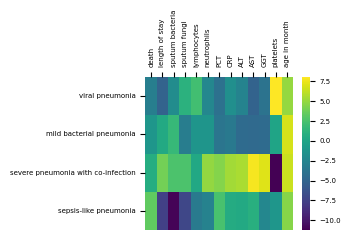

In [91]:
with plt.rc_context({"figure.figsize":(3.5,2.5)}):    
    
    plt.yticks(fontsize=5, family='helvetica')
    plt.xticks(fontsize=5, family='helvetica')
    #plt.savefig("fig3_anot_pneumonia.png", bbox_inches='tight', dpi=300)
    
    ax = sns.heatmap(result, cmap="viridis")
    ax.set(xlabel="", ylabel="")
    ax.set_yticklabels(["viral pneumonia","mild bacterial pneumonia", "severe pneumonia with co-infection", "sepsis-like pneumonia"])
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=5)
    ax = plt.gca()

    # Lower the font size of x-axis tick labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=5)
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='y', rotation=0)
    ax.xaxis.tick_top()
    plt.tight_layout()
    plt.savefig("./fig_3_feature_heatmap.png") 
    plt.show()

# Part D

In [5]:
preprocessed_df = pd.read_csv("/home/thelichking/Desktop/per_day.csv")
# should remove this earlier
preprocessed_df.drop(["language", "religion", "marital_status"], inplace=True, axis=1)
# focus on infants
preprocessed_df = preprocessed_df.loc[(preprocessed_df.age_in_month > 13) & (preprocessed_df.disease_name_1 == "Pneumonia, unspecified")]
# shift negative values for log_norm -> see #402 in ehrapy, do this after anndata creation!
for neg_col in ["Base Excess_min", "Base Excess_max", "Base Excess_avg", "Excrement_avg", "Excrement_min", "Excrement_max"]:
    abs_min = abs(preprocessed_df[neg_col].min())
    preprocessed_df[neg_col] = preprocessed_df[neg_col] + abs_min

/home/thelichking/anaconda3/envs/new_ep_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3397: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
cand_patient = preprocessed_df.loc[preprocessed_df.HADM_ID == 102315]
cand_patient = cand_patient.reset_index()
cand_patient = cand_patient.rename(columns={"index":"day"})
cand_patient['day'] = cand_patient.index

In [7]:
cortison_like = ['Beclomethasone dipropionate inhalation suspension', 'Dexamethasone Sodium Phosphate Injection',
                'Methylprednisolone Sodium Succinate for Injection','Dexamethasone Acetate Tablets', 'Prednisone Acetate Tablets']

anastehtics = ['Phenobarbital Sodium for Injection', 'Lidocaine Hydrochloride Injection','Ibuprofen Suspension',
              'Propofol Injectable Emulsion','Phenobarbital Tablets','Vecuronium Bromide for Injection', 'Indometacin Enteric-coated Tablets']

respiratory_drugs = ['Salbutamol Sulfate Nebules Inhalation Solution', 'Ambroxol Hydrochloride and Glucose Injection', 'Terbutaline Sulphate Solution for Nebulization']

cardiovascular_drugs = ['Urokinase for Injection','Captopril Tablets', 'Human Prothrombin Complex', 'Nifedipine Tablets',
                       'Digoxin Oral Solution', 'Nimodipine Injection', 'Spironolactone Tablets', 'Furosemide Injection']

electrolytes_solutions = ['10% Potassium Chloride Injection', 'Concentrated Sodium Chloride Injection', 
                         'Sterile Water Injection', '(4:1)Glucose and Sodium Chloride Injection', '10% Potassium Chloride Oral Solution',
                         '5% Glucose and Sodium Chloride Injection', ]

In [8]:
drugs = set(pd.unique(cand_patient.columns[15:215]))

ab_matches = ["amoxi", "cef", "clinda", "imi", "mero", "azit", "vanco", "tige", "linezol", "cillin", "mycin", "levoflo", "Sulfamethoxazole", "nitrofur"]
catecholamines_matches = ["epineph", "adrena", "isopren", "dobut", "dopamin"]
antiviral_matches = ["vir"] 
antifungal_matches = ["caspofu", "voricona", "flucona", "fungi"]
ab, cats, vir, fung, rest = [],[],[],[],[]

for drug_ in drugs:
    if any([drug in drug_.lower() for drug in ab_matches]):
        ab.append(drug_)
    elif any([drug in drug_.lower() for drug in catecholamines_matches]):
        cats.append(drug_)
    elif any([drug in drug_.lower() for drug in antiviral_matches]):
        vir.append(drug_)
    elif any([drug in drug_.lower() for drug in antifungal_matches]):
        fung.append(drug_)
    else:
        rest.append(drug_)

In [9]:
prescriptions_df = pd.read_csv("/home/thelichking/Desktop/pediatric_intensive_care_db/paediatric-intensive-care-database-1.1.0/V1.1.0/PRESCRIPTIONS.csv")
prescriptions_df = prescriptions_df[["HADM_ID", "STARTDATE", "DRUG_NAME_EN", "DOSE_VAL_RX"]]
prescriptions_df = prescriptions_df.loc[prescriptions_df.HADM_ID == 102315]
prescriptions_df['STARTDATE'] = prescriptions_df['STARTDATE'].str.split(' ').str.get(0)

In [10]:
prescriptions_df['STARTDATE'] = pd.to_datetime(prescriptions_df['STARTDATE']) 
date_range = list(pd.date_range(start="2092-12-30", end="2093-01-13"))
date_dct = {}
for idx, date in enumerate(date_range):
    date_dct[str(date.date())] = idx
prescriptions_df['STARTDATE'] = prescriptions_df['STARTDATE'].astype(str)
prescriptions_df['days_since_admission'] = prescriptions_df['STARTDATE'].map(date_dct)

In [11]:
prescriptions_df["drug_class"] = prescriptions_df['DRUG_NAME_EN'].apply(lambda drug: "Antibiotic" if drug in ab else 'Antiviral' if drug in vir else 'Antifungal' if drug in fung else 'Catecholamines' if drug in cats else
                                                                        'Cortisol_like' if drug in cortison_like else 'Anaesthetic' if drug in anastehtics else 'Respiratory_drug' if drug in respiratory_drugs else 
                                                                        'Cardiovascular_drug' if drug in cardiovascular_drugs else 'Electrolytes' if drug in electrolytes_solutions else 'Rest')
prescriptions_df.drop(["HADM_ID", "STARTDATE", "DRUG_NAME_EN"], inplace=True, axis=1)

In [12]:
prescriptions_df_no_rest = prescriptions_df.loc[prescriptions_df["drug_class"] != "Rest"]

In [13]:
drug_classes_daily_dose = prescriptions_df_no_rest.groupby(["days_since_admission", "drug_class"]).agg({"DOSE_VAL_RX":"sum"})

In [14]:
drug_classes_daily_dose = drug_classes_daily_dose.unstack().fillna(0)
drug_classes_daily_dose.columns = drug_classes_daily_dose.columns.droplevel(0)
drug_classes_daily_dose = drug_classes_daily_dose.rename_axis(None, axis=1)

In [15]:
cand_frame = cand_patient[["day", "Neutrophils_max", "C-Reactive Protein_max", "Procalcitonin_max", "Alanine Aminotransferase (ALT)_max", "Monocytes_max"]]
cand_frame = cand_frame.assign(Antibiotic = drug_classes_daily_dose["Antibiotic"], Antiviral = drug_classes_daily_dose["Antiviral"], Catecholamines = drug_classes_daily_dose["Catecholamines"], Cortisol_like = drug_classes_daily_dose["Cortisol_like"], Cardiovascular = drug_classes_daily_dose["Cardiovascular_drug"], Electrolytes = drug_classes_daily_dose["Electrolytes"])

In [16]:
cand_frame = cand_frame.rename(columns={'Cortisol_like': 'Corticosteroids (mg/ml)', 'Cardiovascular': 'Anticoagulants (mg)',
                              "Antibiotic": "Antibiotics (mg)", "Antiviral": "Antivirals (mg)", "Catecholamines": "Catecholamines (mg/ml)", 
                                       "Electrolytes": "Electrolytes (ml)"})
cand_frame = cand_frame.rename(columns={'C-Reactive Protein_max': 'C-Reactive Protein (mg/dl)', "Monocytes_max": "Monocytes (10⁹/L)", 
                                        "Neutrophils_max": "Neutrophils (10⁹/L)", "Procalcitonin_max": "Procalcitonin (ng/ml)", 
                                        "Alanine Aminotransferase (ALT)_max": "Alanine Aminotransferase (ALT) (U/L)"})

In [83]:
df = cand_frame[["day", "Antibiotics (mg)", "Antivirals (mg)", "Catecholamines (mg/ml)", "Corticosteroids (mg/ml)", "Anticoagulants (mg)", "Electrolytes (ml)"]]

findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans.


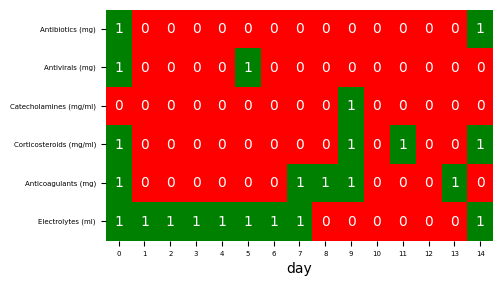

In [84]:
# Set 'day' as the index for better visualization
# Set 'day' as the index for better visualization
df.set_index('day', inplace=True)
df=df.T
# Create a binary grid (0 for values <= 0, 1 for values > 0)
binary_grid = (df > 0).astype(int)
cmap=["red", "green"]

# Display the binary grid
plt.figure(figsize=(5, 3))
plt.yticks(fontsize=5, family='helvetica')
plt.xticks(fontsize=5, family='helvetica')
sns.heatmap(binary_grid, cmap=cmap, annot=True, fmt="d", cbar=False)
plt.show()

<ipython-input-117-b2b6d32ebb37>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(["Antibiotics (mg)", "Antivirals (mg)", "Catecholamines (mg/ml)", "Corticosteroids (mg/ml)", "Anticoagulants (mg)", "Electrolytes (ml)"][::-1], fontsize=7, fontfamily="helvetica")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

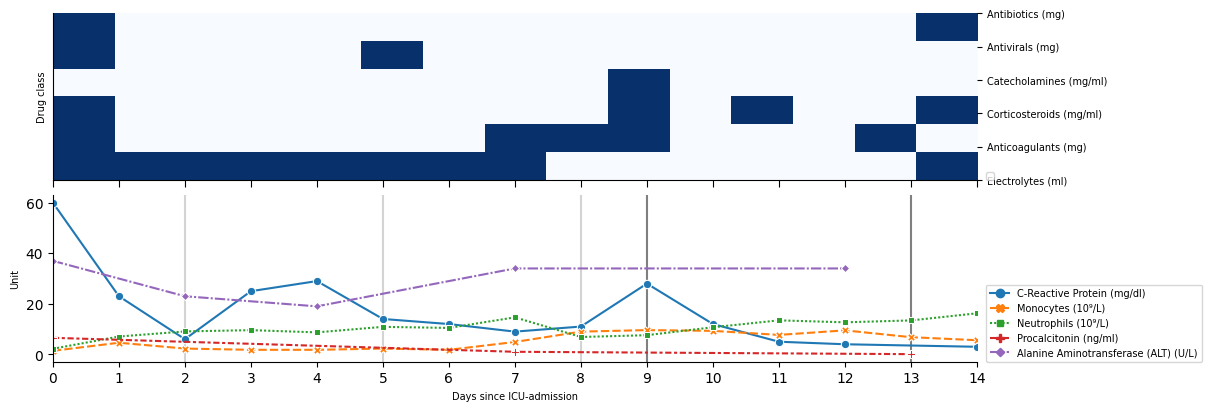

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, figsize=(12, 4), sharex=True, layout='constrained')
ax[0].set_xlim(0,14)
ax[0].set_xticks(range(0,15))
ax[0].tick_params(axis='x', size =5)
plt.axvline(2, color='lightgrey') # cultures negative
plt.axvline(5, color='lightgrey') # cultures negative
plt.axvline(8, color='lightgrey') # cultures negative
plt.axvline(9, color='grey') # sputum culture Acinetobacter baumanii
plt.axvline(13, color='grey') # sputum culture G+ cocci
ax[1].set_xlabel("Days since ICU-admission", fontsize =7, fontfamily="helvetica")
ax[1].set_ylabel("Unit", fontsize =7, fontfamily="helvetica")
ax[0].set_ylabel("Drug class", fontsize =7, fontfamily="helvetica")
ax[0].set_yticklabels(["Antibiotics (mg)", "Antivirals (mg)", "Catecholamines (mg/ml)", "Corticosteroids (mg/ml)", "Anticoagulants (mg)", "Electrolytes (ml)"][::-1], fontsize=7, fontfamily="helvetica")
ax[0].tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)
g = sns.lineplot(data=cand_frame[["C-Reactive Protein (mg/dl)", "Monocytes (10⁹/L)", "Neutrophils (10⁹/L)", "Procalcitonin (ng/ml)", "Alanine Aminotransferase (ALT) (U/L)"]], markers=True)
# Display the binary grid on top of the existing plot
ax[0].imshow(binary_grid.values, cmap="Blues", aspect='auto',extent=[0, 14, 0, 1])

#g_2 = cand_frame[["Antibiotics (mg)", "Antivirals (mg)", "Catecholamines (mg/ml)", "Corticosteroids (mg/ml)", "Anticoagulants (mg)", "Electrolytes (ml)"]].plot.bar(stacked=True, ax=ax[0])
#g_2.set_yscale("log")
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
legend_properties = {'family': 'helvetica', 'size': 7}
ax[0].legend(loc=(1.01, 0), prop=legend_properties)
ax[1].legend(loc=(1.01, 0), prop=legend_properties)
plt.savefig("./fig3_single_patient_lineplot.png")
plt.show()

In [52]:
s = pneumonia_adata_subset.obs.loc[adata.obs.HADM_ID == 102315]
s["Pneumonia unspecified - annotated"] # example patient is in the severe pneumonia with co-infection category

2349    severe pneumonia with co-infection (n=74)
Name: Pneumonia unspecified - annotated, dtype: category
Categories (4, object): ['mild bacterial pneumonia (n=78)', 'sepsis-like pneumonia (n=28)', 'severe pneumonia with co-infection (n=74)', 'viral pneumonia (n=97)']